## 데이터 탐색

In [ ]:
# L.RD, L.Vac : 타겟
# 그 외 : 피쳐 

In [2]:
import pandas as pd 
import numpy as np

In [3]:
factory_df = pd.read_csv('../data/factory_glass_2016.csv', encoding= 'cp949')
factory_df.info() # 8145 data, 842 columns
factory_df.head()
len(factory_df.index)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8145 entries, 0 to 8144
Columns: 841 entries, dat...date.name. to R.Vac
dtypes: float64(834), int64(6), object(1)
memory usage: 52.3+ MB


8145

- 결측치 제거

In [4]:
# 각 컬럼의 결측치 수 확인
missing_values_columns = factory_df.isnull().sum() 
# print(missing_values_columns[missing_values_columns > 0])  # 결측치가 있는 컬럼만 출력
# print(missing_values_columns[missing_values_columns > 8000]) # 7개의 열 - 결측치 8145

drop_df = factory_df.drop(missing_values_columns[missing_values_columns == 8145].index, axis= 1) 
drop_df.info() # column 841 > 834 : 7개의 컬럼 삭제

missing_values_columns = drop_df.isnull().sum()
# print(missing_values_columns[missing_values_columns > 0]) # 127개의 column 결측치 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8145 entries, 0 to 8144
Columns: 834 entries, dat...date.name. to R.Vac
dtypes: float64(827), int64(6), object(1)
memory usage: 51.8+ MB


In [ ]:
# 각 인덱스의 결측치 수 확인
missing_values_rows = drop_df.isnull().sum(axis= 1)
print(missing_values_rows[missing_values_rows > 0]) # 3754 index : 1, 6310 index : 39, 8044 index : 87 -> 6310, 8044 index 삭제
print()
# 8044 -> 1은 보간법으로 채움 - 시계열 데이터의 경우 선형 보간법 혹은 시간 기반 보간법
drop_df = drop_df.drop(missing_values_rows[missing_values_rows > 0].index[-2:], axis= 0)
drop_df.reset_index(drop= True, inplace= True) # 8145 index > 8143 index
drop_df.info() # 
print()
# 행 삭제, 보간 적용 확인
missing_values_rows = drop_df.isnull().sum(axis= 1)
missing_values_rows[missing_values_rows > 0] # 없는 것 확인

# 보간법 imputer 사용 방법
# from sklearn.impute import SimpleImputer
# imputer = SimpleImputer(strategy = 'median')

3754     1
6310    39
8044    87
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Columns: 834 entries, dat...date.name. to R.Vac
dtypes: float64(827), int64(6), object(1)
memory usage: 51.8+ MB



3754    1
dtype: int64

- Right 피쳐 제거

In [ ]:
# LEFT, RIGHT / L.,R. / l_,r_ / _L, _R 간의 상관계수 파악
left_cols = drop_df.filter(regex=r'\b(LEFT|Left|L\.|l_|_L)\b').columns.tolist()
right_cols = drop_df.filter(regex=r'\b(RIGHT|Right|R\.|r_|_R)\b').columns.tolist()

import re

# LEFT와 RIGHT 열을 매칭하기 위한 딕셔너리 생성
left_right_pairs = {}

# LEFT 열 이름 처리
for left_col in left_cols:
    # 숫자를 제외하고 동일한 열 쌍으로 생성
    process_id = re.sub(r'(\.L\.|L\.|LEFT|l_|_L|\d+)', '', left_col, flags=re.IGNORECASE) # 수치를 제외한 나머지가 동일, re.IGNORECASE : 대소문자 구별없음
    if process_id not in left_right_pairs:
        left_right_pairs[process_id] = {'left': left_col, 'right': None}
    else:
        left_right_pairs[process_id]['left'] = left_col

# RIGHT 열 이름 처리
for right_col in right_cols:
    process_id = re.sub(r'(\.R\.|R\.|RIGHT|r_|_R|\d+)', '', right_col, flags=re.IGNORECASE)
    if process_id not in left_right_pairs :
        left_right_pairs[process_id] = {'left': None, 'right': right_col}
    else:
        left_right_pairs[process_id]['right'] = right_col

left_right_pairs
correlation_results = []

for process_id, cols in left_right_pairs.items():
    left_col = cols['left']
    right_col = cols['right']
    
    # 각 쌍의 열 선택
    if left_col in drop_df.columns and right_col in drop_df.columns:
        correlation = drop_df[left_col].corr(drop_df[right_col])
        correlation_results.append((process_id, left_col, correlation))

# 결과를 DataFrame으로 변환
correlation_df = pd.DataFrame(correlation_results, columns=['Pair_ID', 'Left_col', 'Correlation'])

# 상관계수 결과 확인
correlation_df


,Pair_ID,Left_col,Correlation
0,DB.N.SCREEN.FLOW..FI_PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,0.998776
1,.edge,Left.edge,0.190923
2,TMP.TIN..BAY...TI.PV,TMP.TIN..BAY.10.LEFT.1TI30209.PV,0.877271
3,X..BAY..PRESSURE.CLBAY_CPV,X.7.BAY.LEFT.PRESSURE.1CLBAY7LEFT_CPV,0.645692
4,RET.AMBIANT..TMP.TI.PV,RET.AMBIANT.LEFT.TMP.1TI42602.PV,0.991632
5,BATH.AMBIENT..BAY..TI_PV,BATH.AMBIENT.3.BAY.LEFT.1TI31003_PV,0.048482
6,DB.N.SCREEN.FLOW..FI_PV.,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV.1,0.998529
7,EXIT.LIP.PLATE..TI.PV,EXIT.LIP.PLATE.LEFT.1TI30604.PV,0.957144
8,TMP.GLASS...EXIT.TIC.PV,TMP.GLASS..LEFT.EXIT.1TIC30109.PV,-0.323766
9,DROSS.BOX.N.BTM.HTJI.PV,DROSS.BOX.N2.BTM.HT1.L.1JI39005.PV,0.937737


c:\Users\chjin\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 53804 (\N{HANGUL SYLLABLE TU}) missing from current font.
  fig.canvas.draw()
c:\Users\chjin\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 51077 (\N{HANGUL SYLLABLE IB}) missing from current font.
  fig.canvas.draw()
c:\Users\chjin\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from current font.
  fig.canvas.draw()
c:\Users\chjin\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 44277 (\N{HANGUL SYLLABLE GONG}) missing from current font.
  fig.canvas.draw()
c:\Users\chjin\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 54056 (\N{HANGUL SYLLABLE PAE}) missing from current font.
  fig.canvas.draw()
c:\Users\chjin\anaconda3\Lib\site-packages\seaborn\utils.py:80: UserWarning: Glyph 46300 (\N{HANGUL SYLLABLE DEU}) missing from current font.
  fig.canvas.draw()
c:\Users\chjin\anaconda3\Lib\

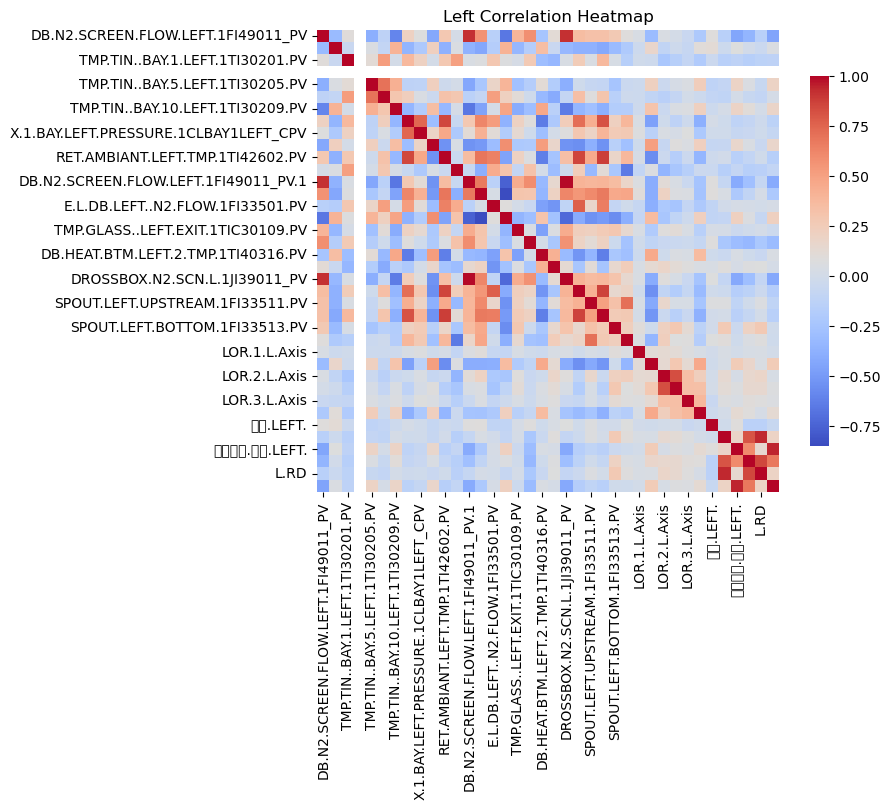

c:\Users\chjin\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


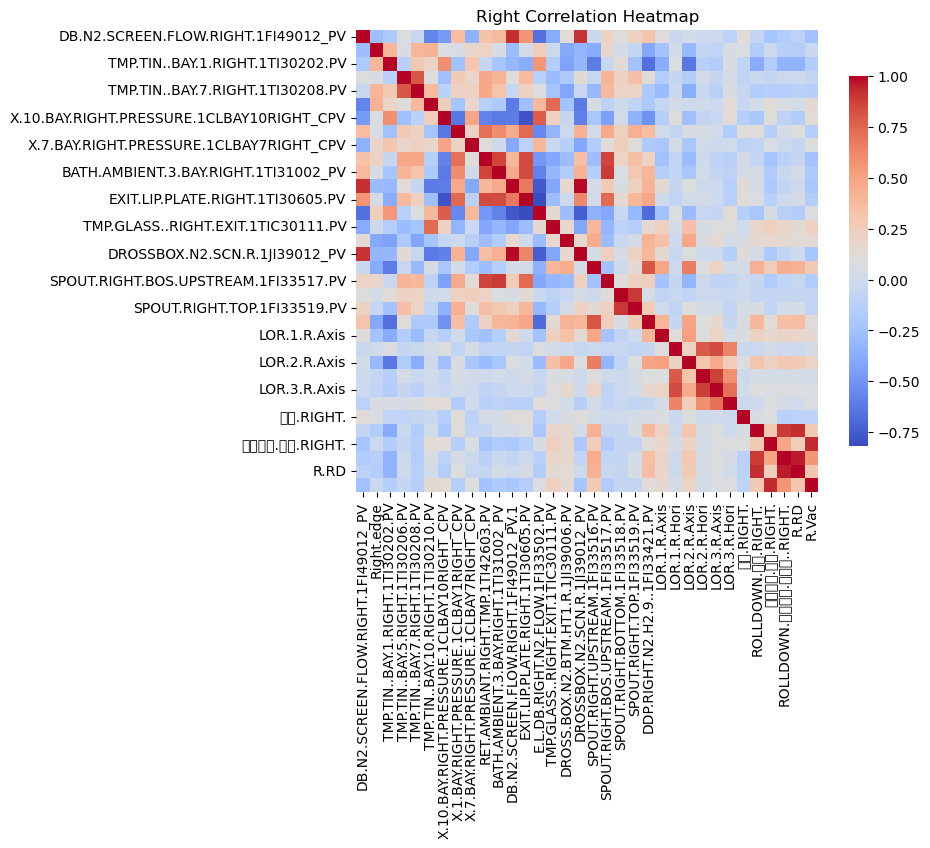

In [72]:
# LEFT, RIGHT 개별 히트맵
left_cols = drop_df.filter(regex=r'\b(LEFT|Left|L\.|l_|_L)\b').columns.tolist()
right_cols = drop_df.filter(regex=r'\b(RIGHT|Right|R\.|r_|_R)\b').columns.tolist()

left_drop_df = drop_df[left_cols]
right_drop_df = drop_df[right_cols]

left_corr = left_drop_df.corr()
right_corr = right_drop_df.corr()

import matplotlib.pyplot as plt
import seaborn as sns

# 왼쪽 상관 행렬 히트맵
plt.figure(figsize= (8, 6))
sns.heatmap(left_corr,fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8}) # annot= True
plt.title('Left Correlation Heatmap')

# 오른쪽 상관 행렬 히트맵
plt.figure(figsize= (8, 6))
sns.heatmap(right_corr, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={'shrink': .8})
plt.title('Right Correlation Heatmap')
plt.show()


In [7]:
# drop_df.info()
drop_df.select_dtypes(object) # 날짜
# 그 외 데이터는 모두 수치형 데이터

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# LEFT, RIGHT 이름의 공정 중 LEFT,RIGHT만 다르고 공정명 동일 - 중요 공정 파악 문제이므로 둘 중 하나만 남김
# 단 LEFT/RIGHT를 제외한 공정명 동일해야 하고 공정번호 다른건 OK
# UPPER, LOWER은 공정의 비가 동일하지 않아 다른 공정일 수 있어서 삭제하지 않음
# 결과 도출 시 LEFT가 중요하면 RIGHT도 중요한지 한 번 확인
# features = drop_df.columns.tolist()
# for feature in features:
#     print(feature)

# LEFT, RIGHT / L.,R. / l_,r_ / _L, _R - 상관계수 파악
left_right_cols = drop_df.filter(regex=r'\b(LEFT|RIGHT|Left|Right|L\.|R\.|l_|r_|_L|_R)\b').columns.tolist()
print(len(left_right_cols))
# for column in left_right_cols :
#   print(column) # 71

right_drop_cols = drop_df.filter(regex=r'\b(RIGHT|Right|R\.|r_|_R)\b').columns.tolist()
print(len(right_drop_cols))
# for col in right_drop_cols :
#   print(col) # 34

print()
drop_right_df = drop_df.loc[:, ~drop_df.columns.isin(right_drop_cols)]
drop_right_df.info() # 800열

drop_right_df.describe()


71
34

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8143 entries, 0 to 8142
Columns: 800 entries, dat...date.name. to L.Vac
dtypes: float64(796), int64(3), object(1)
memory usage: 49.7+ MB


,LIFT.OUT.ROL.MTR.M1.SPD.1WSI40101,LIFT.OUT.ROL.MTR.M2.SPD.1WSI40102,LIFT.OUT.ROL.MTR.M3.SPD.1WSI40103,LEHR.DRV.MTR..M4.1.SPD.1WSI40104,LEHR.DRV.MTR..M4.2.SPD.1WSI40105,LEHR.DRV.MTR..M5.1.SPD.1WSI40106,LEHR.DRV.MTR..M5.2.SPD.1WSI40107,LEHR.DRV.MTR..M6.1.SPD.1WSI40108,LEHR.DRV.MTR..M6.2.SPD.1WSI40109,LEHR.DRV.MTR..M7.1.SPD.1WSI40110,LEHR.DRV.MTR..M7.2.SPD.1WSI40111,LEHR.DRV.MTR..M8.1.SPD.1WSI40112,LEHR.DRV.MTR..M8.2.SPD.1WSI40113,LEHR.DRV.MTR..M9.1.SPD.1WSI40114,LEHR.DRV.MTR..M9.2.SPD.1WSI40115,DRIVE.MOTOR.M10.1.SPEED.1WSI40116,LEHR.DRV.MTR..M10.2.SPD.1WSI40117,LEHR.DRV.MTR..M11.1.SPD.1WSI40118,DRIVE.MOTOR.M11.2.SPEED.1WSI40119,LEHR.DRV.MTR..M12.1.SPD.1WSI40120,LEHR.DRV.MTR..M12.2.SPD.1WSI40121,LEHR.DRV.MTR..M13.1.SPD.1WSI40122,LEHR.DRV.MTR..M13.2.SPD.1WSI40123,LEHR.DRV.MTR..M14.1.SPD.1WSI40124,LEHR.DRV.MTR..M14.2.SPD.1WSI40125,LEHR.DRV.MTR..M15.1.SPD.1WSI40126,LEHR.DRV.MTR..M15.2.SPD.1WSI40127,LEHR.DRV.MTR..M16.1.SPD.1WSI40128,DRIVE.MOTOR.M16.2.SPEED.1WSI40129,LEHR.DRV.MTR..M17.1.SPD.1WSI40130,LEHR.DRV.MTR..M17.2.SPD.1WSI40131,LEHR.DRV.MTR..M18.1.SPD.1WSI40132,LEHR.DRV.MTR..M18.2.SPD.1WSI40133,DRIVE.MOTOR.M19.1.SPEED.1WSI40134,LEHR.DRV.MTR..M19.2.SPD.1WSI40135,X1WOS45101_PV,X1WOS45102_PV,X1WOS45103_PV,X1WOS45104_PV,X1WOS45105_PV,X1WOS45106_PV,X1WOS45107_PV,X1WOS45108_PV,X1WOS45109_PV,X1WOS45110_PV,DCS_Offset_RPM_M11.1WOS45111_PV,DCS_Offset_RPM_M12.1WOS45112_PV,DCS_Offset_RPM_M15.1WOS45115_PV,DCS_Offset_RPM_M16.1WOS45116_PV,DCS_Offset_RPM_M17.1WOS45117_PV,DCS_Offset_RPM_M18.1WOS45118_PV,DCS_Offset_RPM_M19.1WOS45119_PV,DAMP.POSITION.0.BAY.CTRL.1TIC33420.PV,DAMP.POSITION.1.BAY.CTRL.1TIC33421.PV,DAMP.POSITION.2.BAY.CTRL.1TIC33422.PV,DAMP.POSITION.3.BAY.CTRL.1TIC33423.PV,DAMP.POSITION.4.BAY.CTRL.1TIC33424.PV,DAMP.POSITION.5BAY.CTRL.1TIC33425.PV,DAMP.POSITION.6.BAY.CTRL.1TIC33426.PV,DAMP.POSITION.7.BAY.CTRL.1TIC33427.PV,DAMP.POSITION.8BAY.CTRL.1TIC33428.PV,DAMP.POSITION.9.BAY.CTRL.1TIC33429.PV,DAMP.POSITION10.BAY.CTRL.1TIC33430.PV,DAMP.POSITION.11BAY.CTRL.1TIC33431.PV,DB.N2.SCREEN.FLOW.LEFT.1FI49011_PV,N2.TO.EA1313A.1FI33503A_PV,ROOF.HEATING.Zone.1.1JIC31101.PV,ROOF.HEATING.Zone.2.1JIC31102.PV,ROOF.HEATING.Zone.3.1JIC31103.PV,ROOF.HEATING.Zone.4.1JIC31104.PV,ROOF.HEATING.Zone.7.1JIC31107.PV,ROOF.HEATING.Zone.8.1JIC31108.PV,ROOF.HEATING.Zone.9.1JIC31109.PV,ATM.FLOW.SECT.6.N2.H2.1FI33410.PV,ATM.FLOW.SECT.7.N2.H2.1FI33412.PV,ATM.FLOW.SECT.8.N2.H2.1FI33414.PV,ATM.FLOW.SECT.9.N2.1FIC33415.PV,ATM.FLOW.SECT.9.N2.H2.1FIC33416.PV,ATM.FLOW.SECT.10.N2.H2.1FIC33418.PV,SEC11.N2.1FIC33425.PV,SEC11.N2.H2.9..1FIC33426.PV,cluster,ML.Speed,Ribbon.Speed,Gross.width,Left.edge,UPPER.AB1.Z1.TMP.1TIC41101.PV,UPPER.AB1.Z2.TMP.1TIC41102.PV,UPPER.AB1.Z3.TMP.1TIC41103.PV,UPPER.AB1.Z4.TMP.1TIC41104.PV,UPPER.AB1.Z5.TMP.1TIC41105.PV,UPPER.AB1.Z6.TMP.1TIC41106.PV,UPPER.AB1.Z7.TMP.1TIC41107.PV,LOWER.AB1.Z8.TMP.1TIC41151.PV,LOWER.AB1.Z9.TMP.1TIC41152.PV,LOWER.AB1.Z11.TMP.1TIC41154.PV,LOWER.AB1.Z13.TMP.1TIC41156.PV,LOWER.AB1.Z14.TMP.1TIC41157.PV,UPPER.AB2.Z15.TMP.1TIC41201.PV,UPPER.AB2.Z16.TMP.1TIC41202.PV,UPPER.AB2.Z17.TMP.1TIC41203.PV,UPPER.AB2.Z18.TMP.1TIC41204.PV,UPPER.AB2.Z19.TMP.1TIC41205.PV,UPPER.AB2.Z20.TMP.1TIC41206.PV,UPPER.AB2.Z21.TMP.1TIC41207.PV,LOWER.AB2.Z22.TMP.1TIC41251.PV,LOWER.AB2.Z23.TMP.1TIC41252.PV,LOWER.AB2.Z25.TMP.1TIC41254.PV,LOWER.AB2.Z27.TMP.1TIC41256.PV,LOWER.AB2.Z28.TMP.1TIC41257.PV,UPPER.AB3.Z29.TMP.1TIC41301.PV,UPPER.AB3.Z30.TMP.1TIC41302.PV,UPPER.AB3.Z31.TMP.1TIC41303.PV,UPPER.AB3.Z32.TMP.1TIC41304.PV,UPPER.AB3.Z33.TMP.1TIC41305.PV,UPPER.AB3.Z34.TMP.1TIC41306.PV,UPPER.AB3.Z35.TMP.1TIC41307.PV,LOWER.AB3.Z36.TMP.1TIC41351.PV,LOWER.AB3.Z37.TMP.1TIC41352.PV,LOWER.AB3.Z39.TMP.1TIC41354.PV,LOWER.AB3.Z41.TMP.1TIC41356.PV,LOWER.AB3.Z42.TMP.1TIC41357.PV,UPPER.AB4.Z43.TMP.1TIC41401.PV,UPPER.AB4.Z44.TMP.1TIC41402.PV,UPPER.AB4.Z45TMP.1TIC41403.PV,UPPER.AB4.Z46.TMP.1TIC41404.PV,UPPER.AB4.Z47.TMP.1TIC41405.PV,UPPER.AB4.Z48.TMP.1TIC41406.PV,UPPER.AB4.Z49.TMP.1TIC41407.PV,LOWER.AB4.Z50.TMP.1TIC41451.PV,LOWER.AB4.Z51.TMP.1TIC41452.PV,LOWER.AB4.Z53.TMP.